In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path

In [2]:
torch.manual_seed(42)

In [3]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [4]:
import pathlib 
import numpy as np

data_dir = pathlib.Path("/kaggle/input/100-bird-species/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # creating a list of class names from subdirectory 
len(class_names)

525

In [6]:
class_names

array(['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL',
       'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO',
       'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER',
       'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS',
       'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH',
       'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO',
       'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT',
       'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON',
       'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING',
       'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD',
       'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD',
       'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD',
       'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD',
       'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ',
       'AUSTRAL CANASTERO', 

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os 

def view_random_image(target_dir, target_class):
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  
  return img

Image shape: (224, 224, 3)


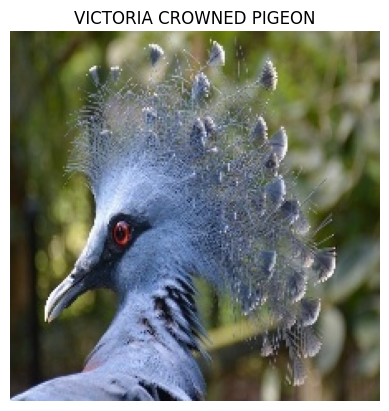

In [28]:
img = view_random_image(target_dir = "/kaggle/input/100-bird-species/train/",
                        target_class = "VICTORIA CROWNED PIGEON") # or we can write nike instead of converse to see converse examples


Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


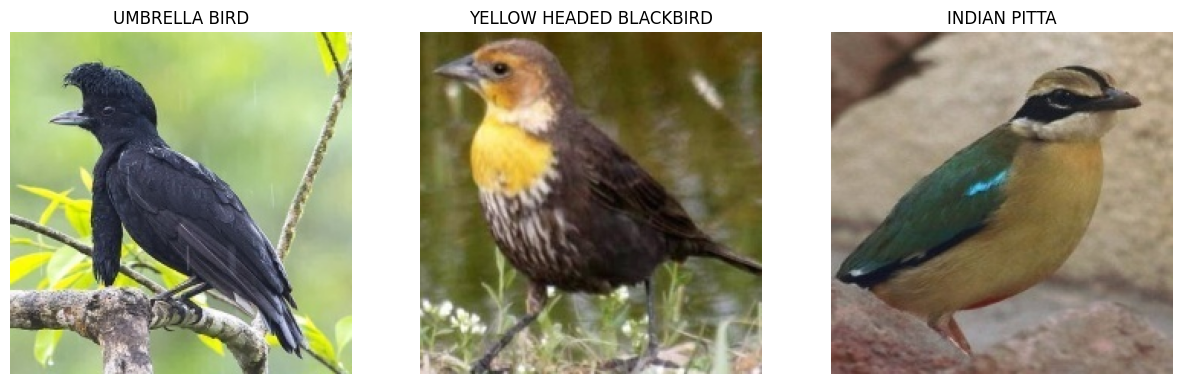

In [29]:
plt.figure(figsize = (15,7))
plt.subplot(1,3,1)
steak_image = view_random_image("/kaggle/input/100-bird-species/train/", "UMBRELLA BIRD")
plt.subplot(1,3,2)
pizza_image = view_random_image("/kaggle/input/100-bird-species/train/", "YELLOW HEADED BLACKBIRD")
plt.subplot(1,3,3)
pizza_image = view_random_image("/kaggle/input/100-bird-species/train/", "INDIAN PITTA")

In [4]:
# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Define data paths
train_path = "/kaggle/input/100-bird-species/train"
val_path = "/kaggle/input/100-bird-species/valid"
test_path = "/kaggle/input/100-bird-species/test"

In [6]:
# Define batch size
batch_size = 64

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
# Load datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

In [10]:
# Load EfficientNet_B0 model with pretrained weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 57.2MB/s]


In [11]:
# Freeze the pretrained parameters
for param in model.parameters():
    param.requires_grad = False

In [12]:
# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [13]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(64, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 525]            --                   Partial
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Set model to training mode
    model.train()

    running_loss = 0.0
    correct_predictions = 0

    # Training phase
    for images, labels in tqdm(train_loader, desc=f'Training - Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_predictions.double() / len(train_dataset)
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_loader, desc=f'Validation - Epoch {epoch + 1}/{num_epochs}', unit='batch'):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_images.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_correct_predictions += torch.sum(val_preds == val_labels.data)

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_accuracy = val_correct_predictions.double() / len(val_dataset)
    print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}')

print('Training complete')

Epoch 1/5
----------


Training - Epoch 1/5: 100%|██████████| 1323/1323 [10:59<00:00,  2.01batch/s]


Training Loss: 2.1355, Accuracy: 0.6500


Validation - Epoch 1/5: 100%|██████████| 42/42 [00:22<00:00,  1.90batch/s]


Validation Loss: 0.7219, Accuracy: 0.8617
Epoch 2/5
----------


Training - Epoch 2/5: 100%|██████████| 1323/1323 [04:21<00:00,  5.06batch/s]


Training Loss: 0.8057, Accuracy: 0.8356


Validation - Epoch 2/5: 100%|██████████| 42/42 [00:08<00:00,  5.05batch/s]


Validation Loss: 0.5191, Accuracy: 0.8857
Epoch 3/5
----------


Training - Epoch 3/5: 100%|██████████| 1323/1323 [03:57<00:00,  5.58batch/s]


Training Loss: 0.5863, Accuracy: 0.8720


Validation - Epoch 3/5: 100%|██████████| 42/42 [00:07<00:00,  5.67batch/s]


Validation Loss: 0.4522, Accuracy: 0.8922
Epoch 4/5
----------


Training - Epoch 4/5: 100%|██████████| 1323/1323 [04:03<00:00,  5.43batch/s]


Training Loss: 0.4665, Accuracy: 0.8946


Validation - Epoch 4/5: 100%|██████████| 42/42 [00:07<00:00,  5.78batch/s]


Validation Loss: 0.4264, Accuracy: 0.8945
Epoch 5/5
----------


Training - Epoch 5/5: 100%|██████████| 1323/1323 [03:56<00:00,  5.60batch/s]


Training Loss: 0.3917, Accuracy: 0.9080


Validation - Epoch 5/5: 100%|██████████| 42/42 [00:07<00:00,  5.78batch/s]

Validation Loss: 0.4034, Accuracy: 0.9002
Training complete


In [16]:
# Test phase
model.eval()
test_correct_predictions = 0

with torch.no_grad():
    for test_images, test_labels in tqdm(test_loader, desc='Testing', unit='batch'):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_outputs = model(test_images)
        _, test_preds = torch.max(test_outputs, 1)

        test_correct_predictions += torch.sum(test_preds == test_labels.data)

test_accuracy = test_correct_predictions.double() / len(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')


Testing: 100%|██████████| 42/42 [00:22<00:00,  1.84batch/s]

Test Accuracy: 0.9238


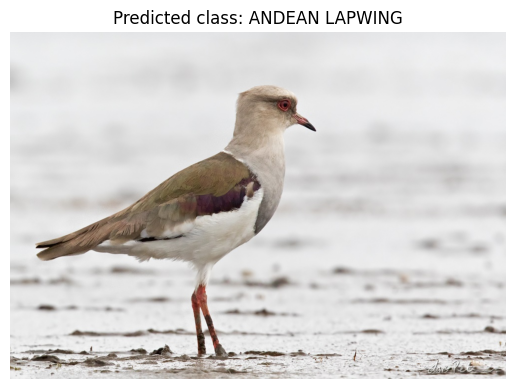

In [39]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Function to load image from URL or local file path
def load_image(image_path):
    if image_path.startswith('http'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image

# URL or local file path of the image you want to test
image_path = "https://th.bing.com/th/id/R.00aaae6a20b045a049fd05e850419560?rik=VuMfjpVHrH1m7A&pid=ImgRaw&r=0"
# Load the image
image = load_image(image_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
preprocessed_image = transform(image).unsqueeze(0)  # Add batch dimension

# Move preprocessed image to the appropriate device
preprocessed_image = preprocessed_image.to(device)

# Pass the preprocessed image through the model
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    outputs = model(preprocessed_image)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = class_names[predicted.item()]

# Display the image and predicted class
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class}')
plt.show()


In [18]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
               f=model_save_path)


In [19]:
save_model(model,'/kaggle/working/','birdingEff.pth')

[INFO] Saving model to: /kaggle/working/birdingEff.pth


In [20]:
# Calculate model size
model_size = Path('/kaggle/working/birdingEff.pth').stat().st_size / (1024*1024)  # in MB
print(f"Model size: {model_size:.2f} MB")

Model size: 18.14 MB


# Load model and Trace it

In [22]:
# Export the model to TorchScript format
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted_save_path = "/kaggle/working/model_scripted.pt"
model_scripted.save(model_scripted_save_path) # Save
print(f"Scripted model saved to: {model_scripted_save_path}")

# Load the model from TorchScript format
class ScriptedEfficientNet(nn.Module):
    def __init__(self):
        super(ScriptedEfficientNet, self).__init__()
        self.model = torch.jit.load(model_scripted_save_path)

    def forward(self, x):
        return self.model(x)

# Instantiate the scripted model
scripted_model_instance = ScriptedEfficientNet().to(device)

# Verify the loaded model
with torch.no_grad():
    scripted_model_instance.eval()  # Set model to evaluation mode
    outputs_scripted = scripted_model_instance(preprocessed_image)

# Get the predicted class from the scripted model
_, predicted_scripted = torch.max(outputs_scripted, 1)
predicted_class_scripted = class_names[predicted_scripted.item()]

print("Predicted class from the scripted model:", predicted_class_scripted)

# Compare the results from the original model and the scripted model
print("Predicted class from the original model:", predicted_class)


Scripted model saved to: /kaggle/working/model_scripted.pt
Predicted class from the scripted model: ASIAN GREEN BEE EATER
Predicted class from the original model: ASIAN GREEN BEE EATER


# LOAD AND CHANGE THE SAVED MODEL TO TFLITE

In [5]:
import torch
import torchvision
import torch.nn as nn

**load and test the model**

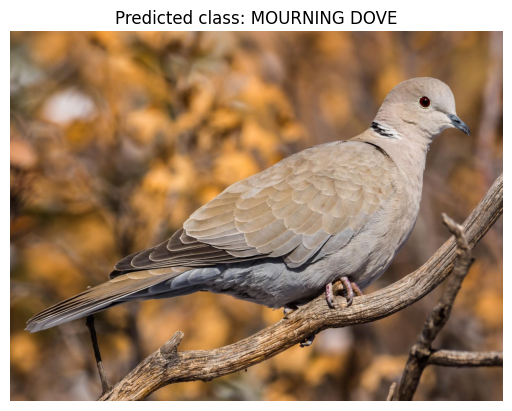

In [6]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Function to load image from URL or local file path
def load_image(image_path):
    if image_path.startswith('http'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image

# URL or local file path of the image you want to test
image_path = "https://th.bing.com/th/id/R.59084385b2f7b033e538d855e37c0b62?rik=NoSpcxcxkZivuQ&pid=ImgRaw&r=0"  # Update with your image URL or file path

# Load the image
image = load_image(image_path)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Preprocess the image
preprocessed_image = transform(image).unsqueeze(0)  # Add batch dimension

# Load the TorchScript model
model = torch.jit.load('/kaggle/input/birding/pytorch/effnet/1/model_scripted.pt')

# Move preprocessed image to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
preprocessed_image = preprocessed_image.to(device)

# Pass the preprocessed image through the model
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    outputs = model(preprocessed_image)

# Convert the output tensor to probabilities
probabilities = torch.softmax(outputs, dim=1)

# Get the predicted class index
predicted_class_index = torch.argmax(probabilities, dim=1).item()

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the image and predicted class
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_name}')
plt.show()



In [7]:
# Example of exporting to ONNX
dummy_input = torch.randn(1, 3, 224, 224).to(device)
input_names = ["input"]
output_names = ["output"]
torch.onnx.export(model, dummy_input, "birdingEff.onnx", input_names=input_names, output_names=output_names)

/opt/conda/lib/python3.10/site-packages/torch/onnx/utils.py:847: UserWarning: no signature found for <torch.ScriptMethod object at 0x7e16453a3c90>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")


In [8]:
!pip install onnx-tf tensorflow

!onnx-tf convert -i birdingEff.onnx -o birdingEff_tflite


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 35.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 whic

# !TODO change the model parameters

In [10]:
# Import necessary libraries
import tensorflow as tf

# Convert ONNX to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model("birdingEff_tflite")  # Load the saved model directory
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('birdingEff0.tflite', 'wb') as f:
    f.write(tflite_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 198, Total Ops 587, % non-converted = 33.73 %
 * 198 ARITH ops

- arith.constant:  198 occurrences  (f32: 164, i32: 34)



  (f32: 9)
  (f32: 65)
  (f32: 16)
  (f32: 1)
  (f32: 65)
  (f32: 17)
  (f32: 65)
  (f32: 17)
  (f32: 65)
  (f32: 66)
